In [1]:
#data handling
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt

#dividing into train/test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model building
from sklearn.ensemble import RandomForestRegressor

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# to persist the model and the scaler
import joblib

# pipeline
from sklearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict


#feature selection method - pca
from sklearn.decomposition import PCA

In [2]:
#defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('../backend/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('../backend/CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('../backend/CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [5]:
train = add_RUL_column(train)

In [6]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

<h1> PCA </h1>

In [7]:
scaler = StandardScaler()


In [20]:
pca = PCA(n_components = 10)

In [21]:
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train.drop(columns = ['RUL'])
X_scaled = scaler.fit_transform(X_train)
x_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test=train_test_split(
    x_pca, #predictor
    X_train['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility

In [22]:
regressor = RandomForestRegressor(random_state=0)

In [23]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [12]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [24]:
pred_train = regressor.predict(X_train)
evaluate(y_train, pred_train, label='train')

pred_test = regressor.predict(X_test)
evaluate(y_test, pred_test)

train set RMSE:3.2180168449920714, R2:0.9978337496647361, MAE:2.4190755487847104
test set RMSE:8.699605961031875, R2:0.9837595556629452, MAE:6.5248497576736675


In [25]:
X_valid = test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
X_val_scaled = scaler.fit_transform(X_valid)
X_valid_pca = pca.fit_transform(X_val_scaled)

In [36]:
new_pred = regressor.predict(X_valid_pca)
new_pred.round()
evaluate(rul, new_pred, label = 'valid')

valid set RMSE:50.490370369011956, R2:-0.47624203935259546, MAE:37.1384


In [41]:
print(new_pred)
print(rul)

[137.32 215.84  43.47  84.54 106.42 100.01 112.11 151.68 172.42 121.62
  99.61 144.17  88.79 143.14 139.05 221.91  60.63  49.74 144.24  21.86
 209.71 138.21 177.1   58.13  86.86 173.35 163.53 125.04 108.7  161.37
  30.6   67.53 159.26   6.27  17.22  49.52  82.76  61.29 143.04  29.02
  55.17  23.96  88.98 158.43 119.79  98.62 181.24 129.91  25.72 115.98
 101.97  31.58  53.63 168.33 130.69  29.99  96.74  97.32 259.62  91.82
  45.94  78.01 115.12  97.39 211.65  19.04 165.82  21.43 131.81  76.24
 197.27  66.44 127.25 190.03 190.45  18.07  25.28 193.03 157.87 165.48
   9.68  10.92 184.24  49.11 109.52  64.9  150.33  93.73  57.57  56.17
  41.92  23.34 101.11 143.78  93.84 222.53  67.57  96.78 218.02  23.83]
    RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]


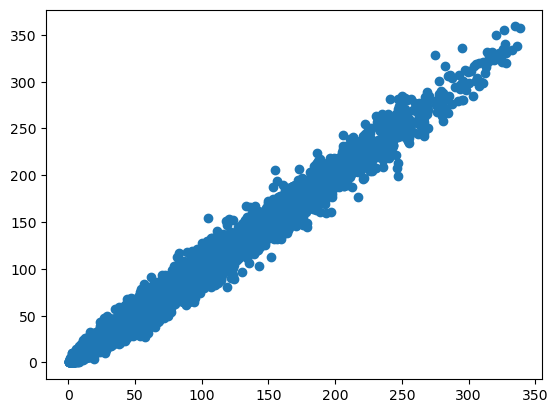

In [15]:
plt.scatter(pred_test, y_test)

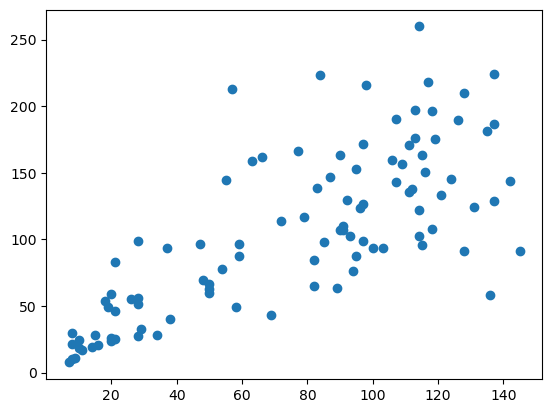

In [18]:
plt.scatter(rul, new_pred)

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set
cv_predictions_train = cross_val_predict(regressor, X_train, y_train, cv=kf)
print("Cross-Validation Scores:", cv_predictions_train)

# Evaluate cross-validated predictions on training set
evaluate(y_train, cv_predictions_train, label='cross-validation on training')

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean_score = cv_predictions_train.mean()
cv_std_score = cv_predictions_train.std()

# Print the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_mean_score)
print("Standard Deviation of CV Scores:", cv_std_score)

# Fit the pipeline to the entire training set
regressor.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = regressor.predict(X_test)

# Evaluate the model on the test set
evaluate(y_test, test_predictions, label='test')

Cross-Validation Scores: [258.48  13.91 153.62 ...  59.23 174.64 165.  ]
cross-validation on training set RMSE:9.309411598928286, R2:0.9818708901187455, MAE:7.075399903053806
Mean CV Score: 107.75851187590887
Standard Deviation of CV Scores: 67.21397576039955
test set RMSE:9.142016150126627, R2:0.9820657709836165, MAE:6.8757609046849755


<h1> Building the Pipeline </h1> 

<ul> 
    <li> building the pre-processing pipeline </li> 
    <li> building the model pipeline </li> 
</ul>
 